In [208]:
# This code tests the trained 3d dq stepper
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#for live plotting
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

%run 3d_ipm_env.ipynb #imports LIPM Env

In [209]:
class NN(nn.Module):
    def __init__(self, inp_size, out_size):
        
        super(NN, self).__init__()
        self.l1 = nn.Linear(inp_size, 512)
        self.l2 = nn.Linear(512, 512)
        self.l3 = nn.Linear(512, 512)
        self.l4 = nn.Linear(512, 512)
        self.l5 = nn.Linear(512, 512)
        self.l6 = nn.Linear(512, 512)
        self.l7 = nn.Linear(512, 512)
        self.l8 = nn.Linear(512, out_size)
    
    def forward(self, x):
        
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = F.relu(self.l5(x))
        x = F.relu(self.l6(x))
        x = F.relu(self.l7(x))
        x = self.l8(x)
        return x

In [210]:
class DQStepper:
    def __init__(self, no_actions = [9, 7], lr = 1e-4, gamma = 0.9, use_tarnet = False, trained_model = None):
        '''
        This is a 3d dq stepper.
        State = [x-ux, y-uy, z-uz, xd, yd, n, action_x, action_y, action_z]
        '''
        self.device = torch.device("cpu")
        self.dq_stepper = NN(11, 1).to(self.device) #state+ action -> q_value
        if trained_model:
            self.dq_stepper.load_state_dict(torch.load(trained_model))
            self.dq_stepper.eval()
        self.optimizer = torch.optim.SGD(self.dq_stepper.parameters(), lr)
        self.use_tarnet = use_tarnet
        if self.use_tarnet:
            self.dq_tar_stepper = NN(11, 1).to(self.device)
            self.dq_tar_stepper.load_state_dict(self.dq_stepper.state_dict())
            self.dq_tar_stepper.eval()
        self.gamma = gamma #discount factor
        assert len(no_actions) == 2
        self.no_actions = no_actions
        
        # This is the template of x_in that goes into the dq stepper
        self.max_step_height = 0.02
        self.delta = 2 #discretization of step height
        self.x_in = np.zeros((self.no_actions[0]*self.no_actions[1], 11))
        self.x_in[:,8] = np.tile(np.arange(self.no_actions[0]), self.no_actions[1])
        self.x_in[:,9] = np.repeat(np.arange(self.no_actions[1]), self.no_actions[0])
                  
    def predict_action_value(self, x):
        # this function predicts the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4, 5, 6, 7]] = x
        self.x_in[:,10] = (1/(self.delta))*self.max_step_height*\
                            np.random.randint(-self.delta, self.delta+1, self.no_actions[0]*self.no_actions[1])
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
            action_index = np.argmin(q_values)
            action_x = int(action_index%self.no_actions[0])
            action_y = int(action_index//self.no_actions[0])
            action_z = self.x_in[action_index,10]
        return [action_x, action_y, action_z], q_values[action_index]
    
    def tar_predict_action_value(self, x):
        # this function uses tar net to predict 
        # the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4, 5, 6, 7]] = x
        self.x_in[:,10] = (1/(self.delta))*self.max_step_height*\
                            np.random.randint(-self.delta, self.delta+1, self.no_actions[0]*self.no_actions[1])
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_tar_stepper(torch_x_in).detach().numpy()
            action_index = np.argmin(q_values)
            action_x = int(action_index%self.no_actions[0])
            action_y = int(action_index//self.no_actions[0])
            action_z = self.x_in[action_index,10]
        return [action_x, action_y, action_z], q_values[action_index]
    
    def predict_eps_greedy(self, x, eps = 0.1):
        # This function returns prediction based on epsillon greedy algorithm
        if np.random.random() > eps:
            return self.predict_action_value(x)[0]
        else:
            action_x = np.random.randint(self.no_actions[0])
            action_y = np.random.randint(self.no_actions[1])
            action_z = 2*self.max_step_height*(np.random.rand() - 0.5)
            return [action_x, action_y, action_z]
        
    def optimize(self, mini_batch, tau = 0.001):
        # This function performs one step of back propogation for the given mini_batch data
        x_in = torch.FloatTensor(mini_batch[:,0:11].copy(), device = self.device)
        y_train = torch.FloatTensor(mini_batch[:,11].copy(), device = self.device)
        for i in range(len(mini_batch)):
            if not np.isnan(mini_batch[i,12:]).all():
                if not self.use_tarnet:
                    y_train[i] += self.gamma * self.predict_action_value(mini_batch[i,12:])[1]
                else:
                    y_train[i] += self.gamma * self.tar_predict_action_value(mini_batch[i,12:])[1]

        y_train = y_train.unsqueeze(1).detach() #ensures that gradients are not computed on this
        x_train = self.dq_stepper(x_in)

        loss = F.mse_loss(x_train, y_train)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.use_tarnet:
            for tar_param, param in zip(self.dq_tar_stepper.parameters(), self.dq_stepper.parameters()):
                tar_param.data.copy_(tar_param.data * (1.0 - tau) + param.data * tau)
                
        return loss
    
    def live_plot(self, history, e, figsize=(15,25), window = 500, title='history'):
        clear_output(wait=True)
        clear_output(wait=True)
        fig, ax = plt.subplots(3, 1, figsize=figsize)
        ax[0].plot(history['epi_cost'], label='epi_cost', color = 'orange')
        ax[0].grid(True)
        ax[0].legend() # the plot evolves to the right
        if e > window:
            ax[1].plot(np.arange(e-window+1, e), history['epi_cost'][e-window:], label='epi_cost zoom')
            ax[1].grid(True)
            ax[1].legend() # the plot evolves to the right
        ax[2].plot(history['loss'], label='loss', color = 'black')
        ax[2].grid(True)
        ax[2].legend() # the plot evolves to the right
        ax[2].set_ylim(0, 60)
        plt.xlabel('episode')
        plt.show();
        
    def predict_q(self, x, terrain):
        #for debugging
        # this function predicts the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4, 5, 6, 7]] = x
        self.x_in[:,10] = terrain
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
            action_index = np.argmin(q_values)
            action_x = int(action_index%self.no_actions[0])
            action_y = int(action_index//self.no_actions[0])
            action_z = self.x_in[action_index,10]
            
        return q_values, [action_x, action_y, action_z] 

In [211]:
ht = 0.28
env = InvertedPendulumEnv(ht, 0.13, 0.22, [0.5, 3, 1.5], [11,9])
no_actions = [len(env.action_space_x), len(env.action_space_y)]
print(no_actions)

dqs = DQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, no_actions= no_actions, trained_model='../../models/bolt/lipm_walking/dqs_3')

[11, 9]


In [212]:
no_steps = 10 ## number of steps simulated per episode (pendulum steps)
step_time = 0.1 ## time after which step is taken

v_des = [0.0, 0]
v_init = [2*(np.random.rand() - 0.5), np.random.rand() - 0.5]
# v_init = [0, 0.0]
print(v_init)
state = env.reset_env([0.0, 0.0, ht, v_init[0], v_init[1]], v_des, no_steps*step_time)
epi_cost = 0
for n in range(no_steps):
    terrain = 0.0*(np.random.randint(-4, 5, no_actions[0]*no_actions[1]))/4.0
    action = dqs.predict_q(state, terrain)[1]
    next_state, cost, done = env.step_env(action, step_time)
    print(action, cost, done, state[3:5])
    epi_cost += cost
    state = next_state
    if done:
        print(epi_cost)
        break
print("showing episode...")
# env.show_episode(5)
# env.show_episode_side(5)



[-0.3689902399165643, 0.40052007620815167]
[3, 5, -0.0] 3.7260544465968426 False [-0.36899024  0.40052008]
[4, 1, 0.0] 2.736538337386958 False [-0.43  0.71]
[6, 6, 0.0] 2.7423414731871865 False [-0.25  0.57]
[5, 2, 0.0] 1.707761890216557 False [0.03 0.78]
[7, 5, 0.0] 2.6255262293050032 False [0.14 0.39]
[5, 3, 0.0] 0.5636741549523724 False [0.3  0.47]
[5, 3, -0.0] 0.38746872575401403 False [0.16 0.02]
[5, 5, 0.0] 1.3066219070895928 False [0.07 0.04]
[4, 1, -0.0] 1.1600021792829278 False [ 0.01 -0.39]
[6, 4, -0.0] 1.4821600763275378 False [-0.04 -0.26]
showing episode...


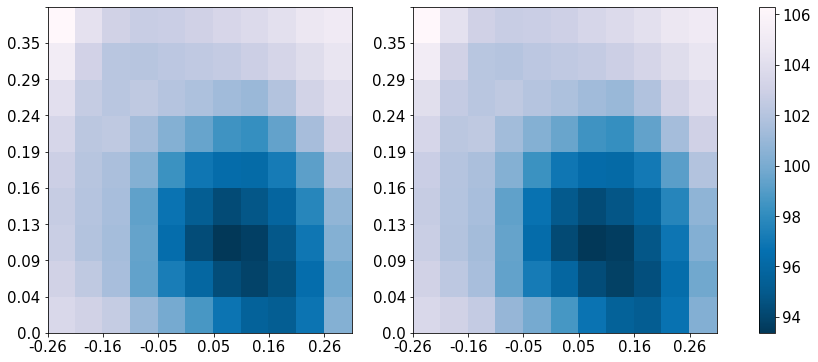

In [637]:
# This block is for visualising the output from the dqstepper
def plot_heatmap(x1, x2, terr_1, terr_2, dqs, env):
    plt.rcParams.update({'font.size': 15})
    q_1 = dqs.predict_q(x1, terr_1)[0]
    q_2 = dqs.predict_q(x2, terr_2)[0]
    n = dqs.no_actions
    q_mat = np.zeros((n[1], n[0]))
    for i in range(len(q_1)):
        q_mat[int(dqs.x_in[i,9]), int(dqs.x_in[i,8])] = q_1[i]
    fig, ax = plt.subplots(1,2, figsize = (15, 6))
    ax[0].set_xticklabels(env.action_space_x[::2])
    ax[0].set_yticklabels(env.action_space_y)
    heatmap = ax[0].pcolor(q_mat, cmap='PuBu_r')
    
    for i in range(len(q_2)):
        q_mat[int(dqs.x_in[i,9]), int(dqs.x_in[i,8])] = q_2[i]
    ax[1].set_xticklabels(env.action_space_x[::2])
    ax[1].set_yticklabels(env.action_space_y)
    heatmap = ax[1].pcolor(q_mat, cmap='PuBu_r')
    
    fig.colorbar(heatmap, ax=ax)
    plt.show()


# dqs = DQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, no_actions= no_actions, trained_model='../../models/bolt/lipm_walking/dqs_3')
dqs = DQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, no_actions= no_actions, trained_model='../../models/dqs_2')
    
x1 = [0, 0, 0.28, -0.5, 0.2, 1, 0, 0]
x2 = [0, 0, 0.28, 0.5, -0.1, 1, 0, 0]

terrain_1 = -0.02*(np.random.randint(-4, 5, no_actions[0]*no_actions[1]))/4.0
terrain_2 = 0.03*(np.random.randint(-4, 5, no_actions[0]*no_actions[1]))/4.0
plot_heatmap(x2, x2, terrain_1, terrain_2, dqs, env)

# x2 = [0, 0, 0.28, 0.5, 0, 1, 0, 0]
# terrain_2 = -0.5*np.ones(no_actions[0]*no_actions[1])
# plot_heatmap(x2, terrain_2, dqs, env)

In [594]:
# This block is to compare cpature regions with analytical capture region
def compute_dcm(state, ht):
    return state[0] + np.sqrt(ht/9.81)*state[1]

def infinite_capture_radius(step_time, max_step_length, ht):
    delta_t = np.sqrt(9.81/ht)*step_time
    return max_step_length*(np.power(np.e, -delta_t))/(1 - np.power(np.e, -delta_t))

def plot_heatmap_with_capture_region(x, next_x, terr, dqs, env):
    plt.rcParams.update({'font.size': 15})
    q_1 = dqs.predict_q(x, terr)[0]
    n = dqs.no_actions
    q_mat = np.zeros((n[1], n[0]))
    for i in range(len(q_1)):
        q_mat[int(dqs.x_in[i,9]), int(dqs.x_in[i,8])] = q_1[i]
    
    dcm_x = compute_dcm([next_x1[0], next_x1[3]], env.h)
    dcm_y = compute_dcm([next_x1[1], next_x1[4]], env.h)
#     print(dcm_x, dcm_y)
    fig, ax = plt.subplots(figsize = (8,5))
    rad = infinite_capture_radius(0.1, env.action_space_x[-1], env.h)
    capture_region = plt.Circle(( dcm_x/0.05 + 5, dcm_y/0.05 + 1), \
                                rad//0.05, fill = False, color = 'red', lw = 2.5)
    dcm = plt.Circle(( dcm_x/0.05 + 5, dcm_y/0.05 + 1), \
                                0.15, fill = True, color = 'red')
    # The +1 and +2 are to correct the offset due to heat map
    # move the circle a bit so that it avoids confusion in the paper (Kin circle should be outside the possinle
    #best actions, which is the case. the issue being that the x labels are not in between in the heatmap)
    kin_region = plt.Circle((next_x[0]/0.05 + 6, next_x[1]/0.05 + 1),\
                            np.sqrt(env.max_leg_length**2 - (env.h - env.com_offset)**2)//0.05, fill = False, color = 'yellow', lw = 2.5)
    ax.add_patch(capture_region)
    ax.add_patch(kin_region)
    ax.add_patch(dcm)
    ax.set_xticklabels(env.action_space_x[::2])
    ax.set_yticklabels(env.action_space_y)
    heatmap = ax.pcolor(q_mat, cmap='PuBu_r')
    ax.set_xlim(0,11)
    ax.set_ylim(0,9)

    ax.vlines(4, 3, 7, color = 'white', lw = 3)
    ax.vlines(6, 2, 3, color = 'white', lw = 3 )
    ax.vlines(10, 2, 7, color = 'white', lw = 3 )
    ax.hlines(3, 4, 6, color = 'white', lw = 3 )
    ax.hlines(7, 4, 10, color = 'white', lw = 3 )
    ax.hlines(2, 6, 10, color = 'white', lw = 3 )

    
    fig.colorbar(heatmap, ax=ax)
    plt.show()

# env.show_episode(5)
# env.show_episode_side(5)



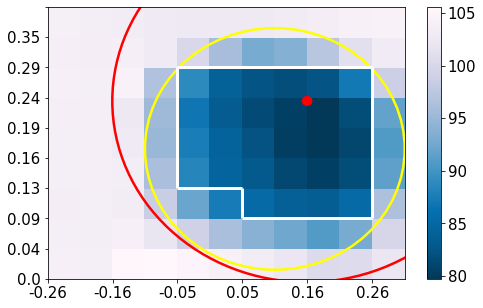

In [628]:
no_steps = 10 ## number of steps simulated per episode (pendulum steps)
step_time = 0.1 ## time after which step is taken

v_des = [0.0, 0]
v_init = [0.5, 0.2]
state = env.reset_env([0.0, 0.0, ht, v_init[0], v_init[1]], v_des, no_steps*step_time)
epi_cost = 0
history = {'state' : [], 'action' : [], 'next_state' : []}
for n in range(no_steps):
    terrain = 0.0*(np.random.randint(-4, 5, no_actions[0]*no_actions[1]))/4.0
    action = dqs.predict_q(state, terrain)[1]
    next_state, cost, done = env.step_env(action, step_time)
    history['state'].append(state)
    history['action'].append(action)
    history['next_state'].append(next_state)
#     print(action, cost, done, state[0:5])
    epi_cost += cost
    state = next_state
    if done:
        break
        
i = 0
x1 = history['state'][i].copy()
next_x1 = history['next_state'][i].copy()
next_x1[0] += env.action_space_x[int(history['action'][i][0])]
next_x1[1] += x1[5]*env.action_space_y[history['action'][i][1]] + 0.13/2.0

terrain_1 = -0.0*(np.random.randint(-4, 5, no_actions[0]*no_actions[1]))/4.0
plot_heatmap_with_capture_region(x1,next_x1, terrain_1,dqs, env)

# print(x1, next_x1, env.action_space_x[history['action'][i][0]], env.action_space_y[history['action'][i][1]])


In [623]:
# This plots all the actions rated from best to worst
state = env.reset_env([0.0, 0.0, ht, v_init[0], v_init[1]], v_des, no_steps*step_time)
terrain = dqs.x_in[:,7:].copy()
terrain[:,3] = 0.0*(np.random.randint(-4, 5, no_actions[0]*no_actions[1]))/4.0
q_values, _ = dqs.predict_q(state, terrain[:,3])
terrain[:,0] = np.reshape(q_values, (len(terrain[:,0],)))
terrain = np.round(terrain[terrain[:,0].argsort()], 2)
print(terrain[0:71])


[[ 78.26   7.     5.     0.  ]
 [ 78.39   7.     4.    -0.  ]
 [ 78.41   6.     5.     0.  ]
 [ 78.66   6.     4.     0.  ]
 [ 79.14   7.     3.     0.  ]
 [ 79.26   5.     5.     0.  ]
 [ 79.46   6.     3.    -0.  ]
 [ 79.69   6.     6.    -0.  ]
 [ 79.76   5.     4.     0.  ]
 [ 80.05   8.     4.     0.  ]
 [ 80.3    5.     6.     0.  ]
 [ 80.31   4.     5.    -0.  ]
 [ 80.33   8.     3.     0.  ]
 [ 80.37   7.     6.    -0.  ]
 [ 80.54   5.     3.     0.  ]
 [ 80.74   8.     5.     0.  ]
 [ 80.86   4.     4.     0.  ]
 [ 81.67   4.     3.     0.  ]
 [ 82.09   4.     6.     0.  ]
 [ 82.41   7.     2.    -0.  ]
 [ 82.44   3.     4.     0.  ]
 [ 82.48   3.     5.     0.  ]
 [ 82.63   6.     2.     0.  ]
 [ 83.4    3.     3.     0.  ]
 [ 83.5    5.     2.    -0.  ]
 [ 84.23   8.     2.     0.  ]
 [ 84.46   3.     6.     0.  ]
 [ 84.64   8.     6.    -0.  ]
 [ 84.98   4.     2.    -0.  ]
 [ 85.68   2.     5.     0.  ]
 [ 86.16   2.     4.    -0.  ]
 [ 87.34   3.     2.    -0.  ]
 [ 87.44

In [624]:
# This is a simulation of the episode where after taking the nth best action it checks if the IPM recovers
state = env.reset_env([0.0, 0.0, ht, v_init[0], v_init[1]], v_des, no_steps*step_time)
epi_cost = 0
history = {'state' : [], 'action' : [], 'next_state' : []}

action_number = 70

for n in range(no_steps):
    terrain = dqs.x_in[:,7:].copy()

    terrain[:,3] = 0.0*(np.random.randint(-4, 5, no_actions[0]*no_actions[1]))/4.0
    q_values, _ = dqs.predict_q(state, terrain[:,3])
    terrain[:,0] = np.reshape(q_values, (len(terrain[:,0],)))
    terrain = np.round(terrain[terrain[:,0].argsort()], 2)
    if n == 0:
        action = [int(terrain[action_number][1]),int(terrain[action_number][2]), terrain[action_number][3]] 
    else:
        action = [int(terrain[0][1]),int(terrain[0][2]), terrain[0][3]]
    next_state, cost, done = env.step_env(action, step_time)
    history['state'].append(state)
    history['action'].append(action)
    history['next_state'].append(next_state)
    print(action, cost, done, state[0:5])
    epi_cost += cost
    state = next_state
    if done:
        print('terminated ...')
        break
        
env.show_episode(10)

[3, 8, 0.0] 2.9558767214537345 False [0.   0.   0.28 0.2  0.25]
[9, 6, 0.0] 3.6412571242689777 False [ 0.13 -0.25  0.28  0.24  0.53]
[8, 2, -0.0] 3.652039438601641 False [-0.03  0.    0.28  0.76 -0.28]
[5, 6, -0.0] 4.004094458502704 False [-0.12 -0.11  0.28  0.78 -0.31]
[6, 0, -0.0] 3.3839256971435394 False [-0.06  0.07  0.28  0.48 -0.79]
[6, 5, 0.0] 3.052511107331706 False [-0.07  0.    0.28  0.36 -0.66]
[4, 1, -0.0] 1.918992357471425 False [-0.09  0.13  0.28  0.18 -0.76]
[3, 2, 0.0] 2.2855483780933765 False [-0.04  0.03  0.28 -0.12 -0.43]
[5, 1, -0.0] 1.113982216887095 False [ 0.05  0.08  0.28 -0.28 -0.4 ]
[5, 2, -0.0] 0.6708219683090457 False [ 0.03  0.01  0.28 -0.13 -0.18]


<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAAsj21kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9OSBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA1CZYiE
AC///vau/MsrRwuVLh1Ze7NR8uhJcv2IMH1oAAADAADXFXgiyfqAyKV8xKpc/vqsqeq2jsA3CMzA
msk1J+HbFyop1KU6qV9ghgRgba0Gk9CuZRZKFKhfEYCByxhLNMCDg5KNzSAAAARyZ7jnH5mHLjmq
03igvEU12KvjwxtOi5cvq34O5jzXx3C67T0ga971HIxJcbQHdVGU+F7IA/YxTaR1ZVfS4b/+tscC
fLIPF+o0Q6jE7LOSOGrexMiWV6qsEqQJJESNnkS1OaVQWOnRL67tI67atMCkj2yYI3JgIZc18fm9
2vCxtquX6Ve0ATSEBlC9g5YGwAj9JJonWjShtj3YDyodxB7SUZHNe4xuetcrqYyo5a5vIVM9az2j
j9/ffxqFfSat/VGgLCP2t1TnEIQNfHp9ISAQYTvb7GumQc3llAYZK++J2N7L8bZHj/lICiTeEZPi
ynN1bMRSFp52pk7YmG5QyxN4dJswB2pwWvba2Vb3fvYWxJ8b52l/4mNGksKVAKrdZm++DOznc3Iv
kenOncG/PBU/e2IgxYUuxaNCtognWq89OIPtD7+o+5A7gBB0lfjfnAPCxNGBKHf/LUNo34YZ8e4Y
uxBGjunUXoCsPlxTlzKIf0XklxmbNWryH2T/5rBsl2xKtNwBexYFCihcWXXi65Mr9EPEU2lLIxJX
d4/Q319nrX0ZlYO7blVw8XNMu4dKa+1UhRxZa4TKbGz6GqUgn6eXVwYMZJy11j/bfiLvMrdmZRyD
ZRQLzIyExfKVE+puFi5NML6fOTIhGdjspgN9XBl4ExhLepC8l/D132wKRWlG4RrAvHsHH2Xxez68
wV5/PXzP+xR9RtNTzwVf11Gj0B3SJCAmQpKaobtkXV9OSni2qBg8bS6xPxbfUHDnwYbKLrkj7r03
fw5CUj0nrJOp6PgTNa0LzjK1B4uUVRGIUYp4Nebe4W34I4Nyv6yZ3+++dtt9w++Y1N66Q3Lq5Plr
1zjhZOmh3CheO74XxDlh2V4ZwjmciQBTfNkANgSc6JjcHvNyoiZ2F4ZGHKkM4iZ8Ak6pvOLWn8Lf
Bo0dQp1w+Q0alAL1y4i79GX+y3WQhsq7gum8Tgo8Nvmpa3gtUUVTJzV+cjQYIsucnXuGmnSFo+m7
Ohn5J49ecEh89iQxnwBdQfpr+v8Ef1Jf/RjJvQ5eYSGTiU1Cd1+QOsC5klvsbX134J7rYEPQNgYh
hGzPf98lW/V2MVaP8XeP0zCHG21vrAYn11WwQEV/E0ED6/N1MD6NbgHb0MkIS2G7dByxvaFCwia5
6vLyQ87hNrFaTk+/GuNhh28JXoXTRWJcvnnPnc0nm3WWKlKv2C1fakxRyYX8dRJ1h4AjdelIpSY3
Nh6tNP7827n94L/PX4CA2JzLYB8XGCM8LliXf6231q1Im1HFznswLyCp6PSKkRZIkZAPgEoBzdgj
fwqAf/21CJ0Y8o9fRVQ7o/EXFVbK0b+yQZEAFD1UtNj3IKQ7+rV90BML6Fd5T6SPOx3qrfFxGceU
x2ACDgg/O2jYZF8f4mNq02OZkjFMbZfr5uqanO3S8LAP9z4/6uDSww35LWcpMKjTjdZ9ETCcGiHy
7Alb7wwSQussPhVYvJ03L4lM7Aa36cJ/B7hNrd4K+PsI8ZQd5Y5paqsXYLji5qY2/++HyvDsbBtM
jJc3Wgrup54cVUDfsMN3YndPOpv8Muc7zhum7Xdr7q/OKQ3CqYff/zYfqfp0ru3HrwOk8mxahDD5
kJNZoS7bXPZ4r5L5Y+9W3OK3NI+PsKCrCKg45jcxUAmzqx4mdVtPL7SoA4ud+UnprQhnVRZmVp9w
06oCmjXpd7KXzP3iSzue9iRF5CXD5x4TZOCcrvhu+NviLeoFcNCkNfQRbCGfERXoFQZReXw9+FPi
go5VgOoM2wiawaIIhdRSDDAiceFpaWF91ZPBMWqCWEzhWvoT7M+ssXMr0TO7gAAAAwBzW816hpPr
bAb9BFNoaB+SoCmOlo2X1NYFhinRhvxEUtiU2KbrAI6mmqlspds1jZaokSbWWv22TgJm+8IuAz5P
cQf1zq6NdXqI5lTDieLcZk/NvSUALQF6wKaODh9D99/dPyPxkgekPrxrNiUM6S7wvsAkE6rMKP0B
jKYXaLCnAhOtP29//3GKPmp/rTc3IX8s4Oaj0tbBDoymRdXKuNUtvAz5LgQSjMUsCjzRy2o4l/Hp
0Z5Oooj8Xf71U0i7FBPQzxx6xFY7W5nbZPBYKXEH8sG1IONP2yy1IxSSJrAgUQfoL2TgW7Ib+KPc
OW7Df9y5baOFMU7Qbls2nU4Oa3YVX4SJsE2WIG2Mkq8kjy9vV5x5XG/rh27tPjqq0o47I0Ihhq+K
WtKnPvVWMLcSx6dUDaEPCgienssBWTB0aeqlG50YAhsNWQxFYCt2un1e8HGyy9Yeo2yGipJwZRYt
lbsxekIS0sHcVBY3HEPNFnb04OfkslI59uh97DYAoOaRM4ag0qZCNjjqsv+2NRnX8Ur9WGJoAByw
TDW5wHGZID9RR+ndGP3G4ZjWCNec2qU+sqmUO2bP/FceWscvvStwBN61/HW5Jzw5rfKqa67hL0M8
roj3n4DiofWEj6J7qzbQ9/k2LGDcpxP3rP+ccBzspxsATNwdtsbCjGaNwaiFJ5iI3Ujl6TQrQuzT
3J51iBOPVKVsHjHYS8QDXmCAGDKRK1OXTts8V0zQ0bmb1zfXbjDjzoVN79BpBm69+AVcgxuNFpH9
XdcETEAubWIqBbwaEmS55JKU7bbMi/1J0SkVrZmEU+b8r0ZtOmZxEeHons3SZSSkvnBPTyRlHrxj
vZCZja6/IC31K7wFmdfDklgACDpQ2k5OMJ7zjiVDCSu9lpJ7M2jmr4r+XYwht5ymzoMCB8/B2bCc
CI9PvxMLSr1W67WhDO5CX